In [1]:
from math import sqrt, isfinite
from typing import Optional

def p_cr_usnavy(E: float, t: float, R: float, L: float, nu: float,
                *, raise_on_invalid: bool = True) -> float:
    """
    Pressão crítica p_cr (Pa) – modelo empírico U.S. Navy (Ventsel, Eq. 19.146).

    Fórmula (com h≡t):
        p_cr = [ 2.42 * E / (1 - nu^2)^(3/4) ] * ( (t/(2R))^(2.5) ) / ( L/(2R) - 0.45*(t/(2R))^(0.5) )

    Parâmetros (SI):
        E  : módulo de Young (Pa)
        t  : espessura (m)  [h em Ventsel]
        R  : raio médio (m)
        L  : comprimento (m)
        nu : coeficiente de Poisson (-)
        raise_on_invalid : se True, lança ValueError quando o denominador ≤ 0;
                           se False, retorna float('nan').

    Retorno:
        p_cr em Pa.

    Observação importante (domínio):
        É necessário L/(2R) > 0.45 * (t/(2R))^(1/2).
        Caso contrário, a expressão fica fora do escopo empírico/sem sentido físico.
    """
    if R <= 0 or t <= 0 or L <= 0 or E <= 0:
        raise ValueError("E, t, R e L devem ser positivos.")

    # termos adimensionais
    eta = t / (2.0 * R)           # t/(2R)
    lam = L / (2.0 * R)           # L/(2R)

    denom = lam - 0.45 * sqrt(eta)
    if denom <= 0.0:
        if raise_on_invalid:
            raise ValueError(
                "Denominador ≤ 0 na Eq. U.S. Navy (19.146). "
                "Requer L/(2R) > 0.45 * (t/(2R))^0.5."
            )
        return float('nan')

    pref = 2.42 * E / ((1.0 - nu**2) ** (3.0 / 4.0))
    pcr  = pref * (eta ** 2.5) / denom
    return pcr


R = 0.15 m, t = 1.0000 mm
L_min (U.S. Navy) = 0.011023 m
L_crítico_curto (Ventsel λ=2.5): 0.030619 m
L_crítico_longo (Ventsel λ=3.35): 6.154343 m


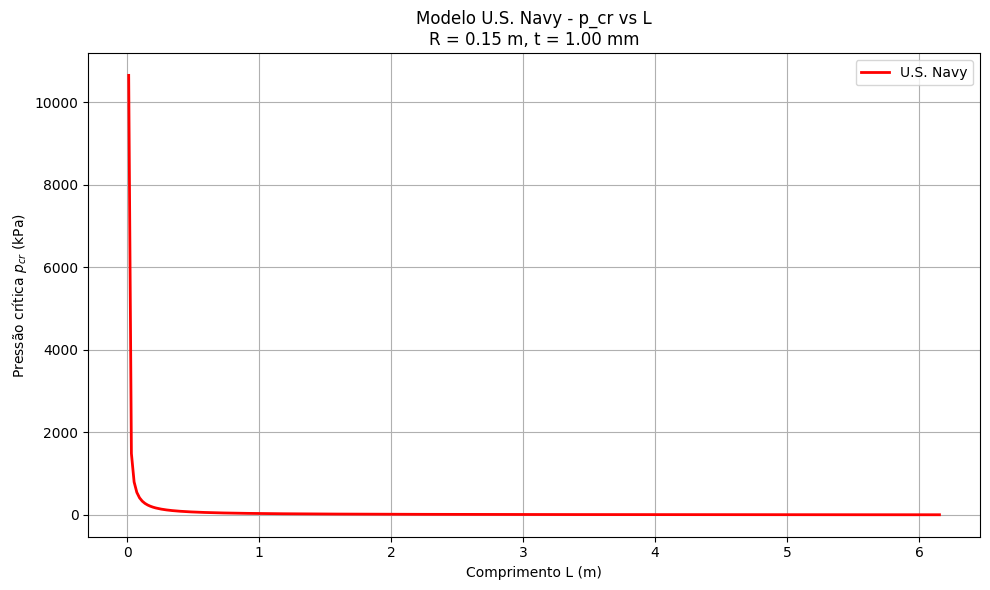


Estatísticas p_cr (U.S. Navy):
  Mínimo: 5783.03 Pa = 5.78 kPa
  Máximo: 10646552.54 Pa = 10646.55 kPa
  Em L = 6.1543 m: 5783.03 Pa = 5.78 kPa


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --------- Parâmetros fixos ---------
E  = 70e9      # Pa
nu = 0.33
t  = 0.001     # m (1 mm)

# Saída
outdir = "figs_ventsel"
os.makedirs(outdir, exist_ok=True)

R_fix = 0.15  # m

# Calcular L_crítico do modelo Ventsel (para referência)
Lcrit_short = 2.5 * sqrt(R_fix * t)         # λ=2.5
Lcrit_long  = 3.35 * R_fix * sqrt(R_fix / t)   # λ=3.35

# Calcular L_min do modelo U.S. Navy (critério de validade)
# L/(2R) > 0.45 * (t/(2R))^0.5
# L > 0.45 * 2R * sqrt(t/(2R))
# L > 0.45 * sqrt(4*R*t)
# L > 0.9 * sqrt(R*t)
L_min_usnavy = 0.9 * sqrt(R_fix * t)

print(f"R = {R_fix:.2f} m, t = {t*1000:.4f} mm")
print(f"L_min (U.S. Navy) = {L_min_usnavy:.6f} m")
print(f"L_crítico_curto (Ventsel λ=2.5): {Lcrit_short:.6f} m")
print(f"L_crítico_longo (Ventsel λ=3.35): {Lcrit_long:.6f} m")

# Iterar sobre L de L_min até Lcrit_long
L_vals = np.linspace(L_min_usnavy * 1.01, Lcrit_long, 300)  # pequena margem após L_min
pcr_L_usnavy = []

for L in L_vals:
    try:
        p = p_cr_usnavy(E, t, R_fix, L, nu, raise_on_invalid=False)
        if isfinite(p) and p > 0:
            pcr_L_usnavy.append(p)
        else:
            pcr_L_usnavy.append(np.nan)
    except:
        pcr_L_usnavy.append(np.nan)

pcr_L_usnavy = np.array(pcr_L_usnavy)

# Criar figura
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(L_vals, pcr_L_usnavy/1000, 'r-', linewidth=2, label='U.S. Navy')

ax.set_xlabel("Comprimento L (m)")
ax.set_ylabel("Pressão crítica $p_{cr}$ (kPa)")
ax.set_title(f"Modelo U.S. Navy - p_cr vs L\nR = {R_fix:.2f} m, t = {t*1000:.2f} mm")
ax.grid(True)
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(outdir, "pcr_vs_L_usnavy.png"), dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(outdir, "pcr_vs_L_usnavy.pdf"), bbox_inches="tight")

plt.show()

# Estatísticas
valid_pcr = pcr_L_usnavy[~np.isnan(pcr_L_usnavy)]
if len(valid_pcr) > 0:
    print(f"\nEstatísticas p_cr (U.S. Navy):")
    print(f"  Mínimo: {np.min(valid_pcr):.2f} Pa = {np.min(valid_pcr)/1e3:.2f} kPa")
    print(f"  Máximo: {np.max(valid_pcr):.2f} Pa = {np.max(valid_pcr)/1e3:.2f} kPa")
    print(f"  Em L = {Lcrit_long:.4f} m: {pcr_L_usnavy[-1]:.2f} Pa = {pcr_L_usnavy[-1]/1e3:.2f} kPa")